In [3]:
import pandas as pd
import sys
import os.path as op 
from numpy.linalg import norm
from gensim.models import FastText
import numpy as np


basename = "/home/adrian/PhD/Tweet-Classification-Diabetes-Distress/"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
from tweet_utils import tweet_vectorizer

from preprocess import Preprocess
prep = Preprocess()

        
def preprocess_tweet(tweet):
    tweet = prep.replace_contractions(tweet)
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="delete", mode_Mentions="delete")
    tweet = prep.remove_repeating_characters(tweet)
    tweet = prep.remove_repeating_words(tweet)
    tweet = prep.tokenize(tweet)
    tweet = prep.remove_punctuation(tweet)
    tweet = prep.to_lowercase(tweet)
    tweet = prep.remove_non_ascii(tweet)
    tweet = prep.replace_numbers(tweet)
    tweet = prep.remove_stopwords(tweet, include_personal_words=False, include_negations=False)
    tweet = [word for word in tweet if word not in ["diabetes", "diabetic"]]
    return tweet

def cosinus_similarity(a, b):
    return np.inner(a,b)/(norm(a)*norm(b))

model = FastText.load("/home/adrian/PhD/Data/FastText_embedding_20190703/ft_wordembeddings_dim300_minCount5_URL-User-toConstant_iter10_20190703")

data = pd.read_parquet("Tweets_groupLabel_20190715.parquet")
data["text_vec"] = data.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model))

data.head()

/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


no embedding for a8 !!!!!!!!!!!!
no embedding for a8 !!!!!!!!!!!!
no embedding for a8 !!!!!!!!!!!!


,id,text,user_name,gender,typeDiabetes,prep,label,text_vec
0,1.129140e+18,When I was initially diagnosed with #type2diab...,Lynda Jimenez,1,1,"[initially, diagnosed, #type2diabetes, almost,...",4,"[0.091667205, 0.032091808, -0.081855804, -0.07..."
1,1.102559e+18,Later Twitter it's back to sleep for a nap wok...,Deanna Porter Weick,0,0,"[later, twitter, back, sleep, nap, woke, 5:30,...",11,"[0.16888438, -0.029450605, 0.0862785, -0.06317..."
2,1.039046e+18,Ugh not ready for this 3hour glucose test tomo...,Esmeralda,2,0,"[ugh, ready, 3hour, glucose, test, tomorrow]",22,"[0.07679383, -0.038904045, 0.13049835, -0.2382..."
3,9.581800e+17,@hotfunkytown They also lock up diabetic suppl...,Joyce Pride,0,0,"[also, lock, supplies, need, gloria, feel, ash...",3,"[0.12150481, 0.11272085, 0.11174324, -0.108990..."
4,9.151822e+17,@I_TheeWed “Hey mom! I know you’re dreading th...,Hot Mess Momma🍁,2,0,"[hey, mom, know, dreading, glucose, test, alre...",3,"[0.06801716, 0.14217816, 0.018431958, -0.32431..."


In [5]:
def get_groupCenter(group, vectorColumn="text_vec"):
    matrix_form = np.asarray(group[vectorColumn].values.tolist())
    groupCenter = np.sum(matrix_form,axis=0) / matrix_form.shape[0]
    
    #group["cos_similarity_to_center"] = group["text_vec"].map(lambda vec: cosinus_similarity(vec, groupCenter))
    #group.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    #print(type(groupCenter), groupCenter.shape)
    return(groupCenter)


dataCenters = data.groupby(by="label", as_index=False) \
              .apply(lambda group: get_groupCenter(group, "text_vec")) \
              .reset_index(drop=True)

print(dataCenters.shape, type(dataCenters))

(30,) <class 'pandas.core.series.Series'>


In [7]:
data.shape

(46407, 8)

In [8]:
cosine_sim_matrix = pd.DataFrame(columns=range(0,30))#columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9",
#                                         "c10", "c11", "c12", "c13", "c14", "c15", "c16", "c17", "c18", "c19",
#                                         "c20", "c21", "c22", "c23", "c24", "c25", "c26", "c27", "c28", "c29"])

cosine_sim_matrix = np.zeros((data.shape[0], 30))
for i, row in data.iterrows():
    for j, center in enumerate(dataCenters):
        #print("i:", i, " j:", j)
        cosine_sim_matrix[i, j] = cosinus_similarity(row["text_vec"], center)
        
    if i % 5000 == 0 :
        print(i)

print(cosine_sim_matrix.shape)

0


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


5000
10000
15000
20000
25000
30000
35000
40000
45000
(46407, 30)


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [9]:
cosine_sim_matrix_pd = pd.DataFrame(cosine_sim_matrix)
cosine_sim_matrix_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.791282,0.669108,0.722288,0.789422,0.897179,0.809238,0.784572,0.781562,0.875914,0.774045,...,0.798114,0.821806,0.705209,0.716898,0.777958,0.748924,0.786805,0.802394,0.823877,0.792698
1,0.777779,0.677034,0.714431,0.788249,0.788799,0.762542,0.766696,0.745560,0.766136,0.754690,...,0.823362,0.752624,0.772959,0.771036,0.757685,0.760285,0.749965,0.766812,0.804816,0.777757
2,0.725706,0.619255,0.644885,0.728903,0.691606,0.683046,0.727878,0.674981,0.673058,0.699553,...,0.746364,0.678024,0.910151,0.709898,0.684963,0.707004,0.673459,0.687651,0.699387,0.714653
3,0.780250,0.639622,0.778312,0.825264,0.741734,0.814218,0.798327,0.792016,0.745632,0.787514,...,0.814234,0.768517,0.696508,0.759176,0.794003,0.768892,0.749713,0.794803,0.780491,0.794746
4,0.826327,0.761986,0.760850,0.867632,0.811426,0.819195,0.799714,0.793929,0.811334,0.812940,...,0.853868,0.795667,0.854687,0.798708,0.781163,0.823555,0.784727,0.810683,0.838773,0.830035


In [10]:
corr = cosine_sim_matrix_pd.corr(method="spearman")
corr.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.000000,0.712294,0.729400,0.920576,0.791880,0.920173,0.755010,0.696610,0.791068,0.832882,...,0.886479,0.882296,0.678533,0.719083,0.880774,0.912570,0.900449,0.912872,0.853223,0.800176
1,0.712294,1.000000,0.622623,0.783413,0.772327,0.692462,0.645662,0.647990,0.802042,0.719628,...,0.863687,0.730648,0.527909,0.597894,0.666696,0.763074,0.747272,0.739162,0.860289,0.680328
2,0.729400,0.622623,1.000000,0.693736,0.596267,0.739565,0.771805,0.732402,0.600825,0.856642,...,0.736968,0.654357,0.388321,0.743695,0.746037,0.773272,0.709410,0.774449,0.651556,0.709402
3,0.920576,0.783413,0.693736,1.000000,0.780115,0.929802,0.709453,0.730873,0.795823,0.763910,...,0.910260,0.872922,0.677319,0.655378,0.853822,0.880718,0.886213,0.912928,0.884878,0.826617
4,0.791880,0.772327,0.596267,0.780115,1.000000,0.785632,0.692458,0.720920,0.964027,0.705941,...,0.833371,0.886853,0.637129,0.548038,0.788008,0.766419,0.834550,0.803594,0.902185,0.750070


'\nAccent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, \nGnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r,\nPastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, \nPurples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, \nSet1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r,\nYlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, \nbwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag,\nflag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, \ngist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gn

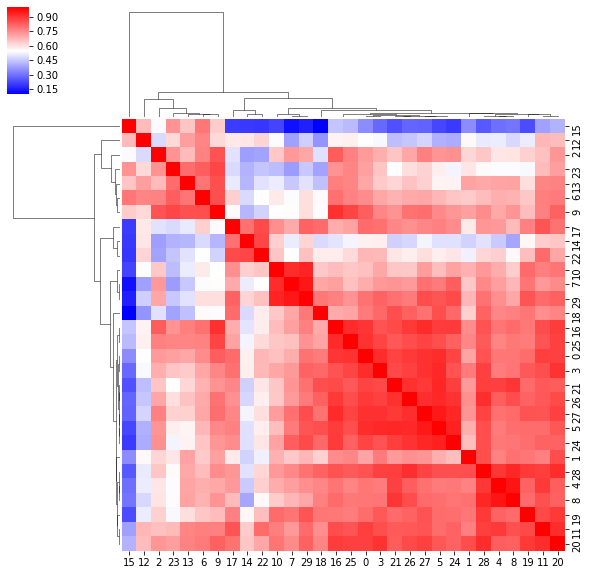

In [36]:
import seaborn as sns
%matplotlib inline
sns.clustermap(corr, metric="cosine", method='average', cmap="bwr") # coolwarm, inferno_r

"""
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, 
GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r,
Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, 
Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, 
Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r,
YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, 
bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag,
flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, 
gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r,
gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma,
magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, 
prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10,
tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, 
twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r
"""